# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [ ]:
# !pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6))  # Adjusted figsize
    axes = axes.ravel()  # Flatten the axes array

    split_name = "train" if "train" in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break  # Stop once we have shown one for each target class

        example = data_split[i]
        label = example["label"]

        if label not in processed_labels and label < num_classes_to_show:
            img = example["image"]
            ax_idx = label  # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis("off")
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list, silent=False):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(
            f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)})."
        )
        return None  # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average="weighted", zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    if not silent:
        # Print Metrics
        print("-" * 25)
        print("Per-Class Metrics:")
        print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
        print("-" * 80)
        for i, name in enumerate(class_names_list):
            # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
            support = per_class_support[i] if i < len(per_class_support) else 0
            prec = per_class_precision[i] if i < len(per_class_precision) else 0
            rec = per_class_recall[i] if i < len(per_class_recall) else 0
            f1s = per_class_f1[i] if i < len(per_class_f1) else 0
            print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
        print("-" * 80)

        # Plot Confusion Matrix
        print("\nPlotting Confusion Matrix...")
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
        disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation="vertical")
        plt.title("Confusion Matrix")
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

    metrics = {
        "accuracy": accuracy,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1,
        "confusion_matrix": cm,
        "per_class_metrics": {
            "precision": per_class_precision,
            "recall": per_class_recall,
            "f1": per_class_f1,
            "support": per_class_support,
        },
    }
    return metrics

# Data

In [4]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed",
    "Merging",
    "Round Smooth",
    "In-between Round Smooth",
    "Cigar Shaped Smooth",
    "Barred Spiral",
    "Unbarred Tight Spiral",
    "Unbarred Loose Spiral",
    "Edge-on without Bulge",
    "Edge-on with Bulge",
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)


Number of classes: 10
Class names: ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth', 'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']


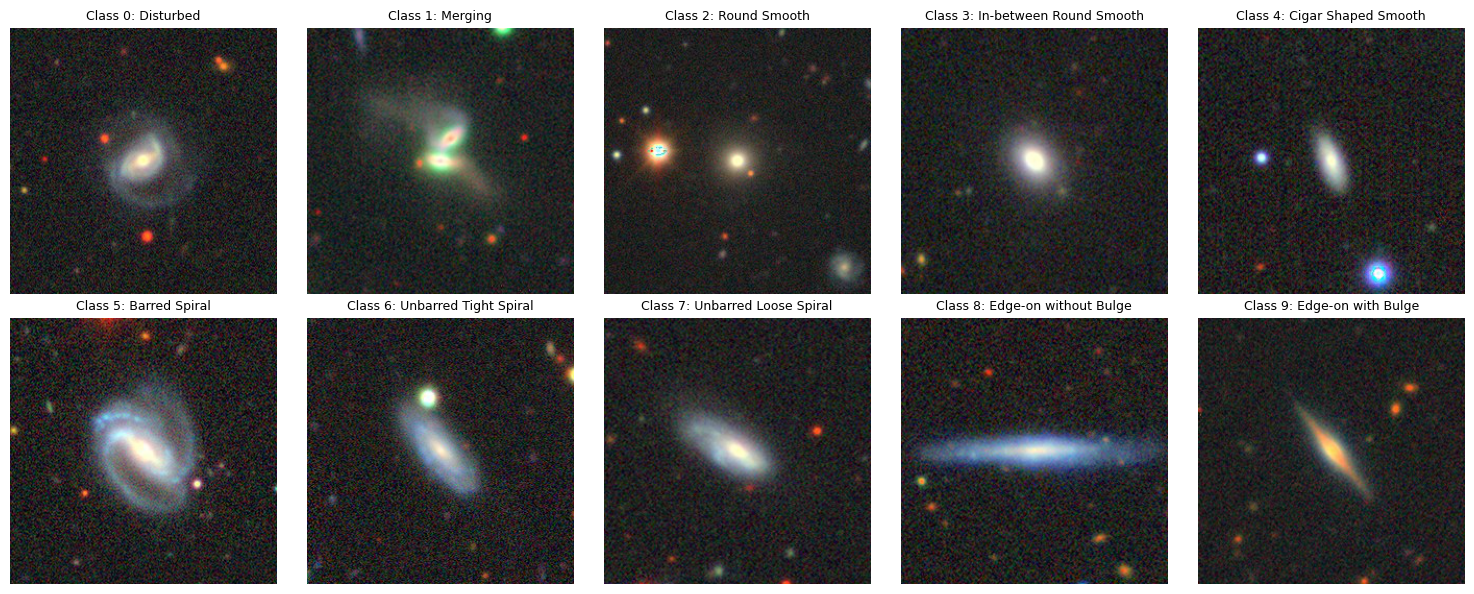

In [5]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Your training code here

In [ ]:
import torch
from tqdm import tqdm
import torchvision
from torch.utils.data import DataLoader

print("Loading data...")

device = torch.device("cuda")
dtype = torch.bfloat16

torch.set_default_dtype(dtype)

galaxy_dataset_train = galaxy_dataset["train"]
galaxy_dataset_test = galaxy_dataset["test"]

train_img_transform = torchvision.transforms.Compose(
    [torchvision.transforms.TrivialAugmentWide(), torchvision.transforms.ToTensor()]
)


def train_transform(data):
    res = {}
    res["pixel_values"] = [train_img_transform(img) for img in data["image"]]
    res["label"] = [torch.tensor(label) for label in data["label"]]
    return res


test_img_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


def test_transform(data):
    res = {}
    res["pixel_values"] = [test_img_transform(img) for img in data["image"]]
    res["label"] = [torch.tensor(label) for label in data["label"]]
    return res


galaxy_dataset_train = galaxy_dataset_train.with_transform(train_transform)
galaxy_dataset_test = galaxy_dataset_test.with_transform(test_transform)

print(galaxy_dataset_train[0]["pixel_values"].shape)
print(galaxy_dataset_train[0]["label"])

torch.Size([3, 256, 256])
tensor(7, device='mps:0')


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Function
import torch.nn as nn
import pywt
from einops import rearrange, repeat
from einops.layers.torch import Rearrange


def sfb1d(lo, hi, g0, g1, mode="zero", dim=-1):
    """1D synthesis filter bank of an image tensor"""
    C = lo.shape[1]
    d = dim % 4
    # If g0, g1 are not tensors, make them. If they are, then assume that they
    # are in the right order
    if not isinstance(g0, torch.Tensor):
        g0 = torch.tensor(np.copy(np.array(g0).ravel()), dtype=torch.float, device=lo.device)
    if not isinstance(g1, torch.Tensor):
        g1 = torch.tensor(np.copy(np.array(g1).ravel()), dtype=torch.float, device=lo.device)
    L = g0.numel()
    shape = [1, 1, 1, 1]
    shape[d] = L
    N = 2 * lo.shape[d]
    # If g aren't in the right shape, make them so
    if g0.shape != tuple(shape):
        g0 = g0.reshape(*shape)
    if g1.shape != tuple(shape):
        g1 = g1.reshape(*shape)

    s = (2, 1) if d == 2 else (1, 2)
    g0 = torch.cat([g0] * C, dim=0)
    g1 = torch.cat([g1] * C, dim=0)
    if mode == "per" or mode == "periodization":
        y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + F.conv_transpose2d(hi, g1, stride=s, groups=C)
        if d == 2:
            y[:, :, : L - 2] = y[:, :, : L - 2] + y[:, :, N : N + L - 2]
            y = y[:, :, :N]
        else:
            y[:, :, :, : L - 2] = y[:, :, :, : L - 2] + y[:, :, :, N : N + L - 2]
            y = y[:, :, :, :N]
        y = roll(y, 1 - L // 2, dim=dim)
    else:
        if mode == "zero" or mode == "symmetric" or mode == "reflect" or mode == "periodic":
            pad = (L - 2, 0) if d == 2 else (0, L - 2)
            y = F.conv_transpose2d(lo, g0, stride=s, padding=pad, groups=C) + F.conv_transpose2d(
                hi, g1, stride=s, padding=pad, groups=C
            )
        else:
            raise ValueError("Unkown pad type: {}".format(mode))

    return y


def reflect(x, minx, maxx):
    """Reflect the values in matrix *x* about the scalar values *minx* and
    *maxx*.  Hence a vector *x* containing a long linearly increasing series is
    converted into a waveform which ramps linearly up and down between *minx*
    and *maxx*.  If *x* contains integers and *minx* and *maxx* are (integers +
    0.5), the ramps will have repeated max and min samples.
    .. codeauthor:: Rich Wareham <rjw57@cantab.net>, Aug 2013
    .. codeauthor:: Nick Kingsbury, Cambridge University, January 1999.
    """
    x = np.asanyarray(x)
    rng = maxx - minx
    rng_by_2 = 2 * rng
    mod = np.fmod(x - minx, rng_by_2)
    normed_mod = np.where(mod < 0, mod + rng_by_2, mod)
    out = np.where(normed_mod >= rng, rng_by_2 - normed_mod, normed_mod) + minx
    return np.array(out, dtype=x.dtype)


def mode_to_int(mode):
    if mode == "zero":
        return 0
    elif mode == "symmetric":
        return 1
    elif mode == "per" or mode == "periodization":
        return 2
    elif mode == "constant":
        return 3
    elif mode == "reflect":
        return 4
    elif mode == "replicate":
        return 5
    elif mode == "periodic":
        return 6
    else:
        raise ValueError("Unkown pad type: {}".format(mode))


def int_to_mode(mode):
    if mode == 0:
        return "zero"
    elif mode == 1:
        return "symmetric"
    elif mode == 2:
        return "periodization"
    elif mode == 3:
        return "constant"
    elif mode == 4:
        return "reflect"
    elif mode == 5:
        return "replicate"
    elif mode == 6:
        return "periodic"
    else:
        raise ValueError("Unkown pad type: {}".format(mode))


def afb1d(x, h0, h1, mode="zero", dim=-1):
    """1D analysis filter bank (along one dimension only) of an image
    Inputs:
        x (tensor): 4D input with the last two dimensions the spatial input
        h0 (tensor): 4D input for the lowpass filter. Should have shape (1, 1,
            h, 1) or (1, 1, 1, w)
        h1 (tensor): 4D input for the highpass filter. Should have shape (1, 1,
            h, 1) or (1, 1, 1, w)
        mode (str): padding method
        dim (int) - dimension of filtering. d=2 is for a vertical filter (called
            column filtering but filters across the rows). d=3 is for a
            horizontal filter, (called row filtering but filters across the
            columns).
    Returns:
        lohi: lowpass and highpass subbands concatenated along the channel
            dimension
    """
    C = x.shape[1]
    # Convert the dim to positive
    d = dim % 4
    s = (2, 1) if d == 2 else (1, 2)
    N = x.shape[d]
    # If h0, h1 are not tensors, make them. If they are, then assume that they
    # are in the right order
    if not isinstance(h0, torch.Tensor):
        h0 = torch.tensor(np.copy(np.array(h0).ravel()[::-1]), dtype=torch.float, device=x.device)
    if not isinstance(h1, torch.Tensor):
        h1 = torch.tensor(np.copy(np.array(h1).ravel()[::-1]), dtype=torch.float, device=x.device)
    L = h0.numel()
    L2 = L // 2
    shape = [1, 1, 1, 1]
    shape[d] = L
    # If h aren't in the right shape, make them so
    if h0.shape != tuple(shape):
        h0 = h0.reshape(*shape)
    if h1.shape != tuple(shape):
        h1 = h1.reshape(*shape)
    h = torch.cat([h0, h1] * C, dim=0)

    if mode == "per" or mode == "periodization":
        if x.shape[dim] % 2 == 1:
            if d == 2:
                x = torch.cat((x, x[:, :, -1:]), dim=2)
            else:
                x = torch.cat((x, x[:, :, :, -1:]), dim=3)
            N += 1
        x = roll(x, -L2, dim=d)
        pad = (L - 1, 0) if d == 2 else (0, L - 1)
        lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
        N2 = N // 2
        if d == 2:
            lohi[:, :, :L2] = lohi[:, :, :L2] + lohi[:, :, N2 : N2 + L2]
            lohi = lohi[:, :, :N2]
        else:
            lohi[:, :, :, :L2] = lohi[:, :, :, :L2] + lohi[:, :, :, N2 : N2 + L2]
            lohi = lohi[:, :, :, :N2]
    else:
        # Calculate the pad size
        outsize = pywt.dwt_coeff_len(N, L, mode=mode)
        p = 2 * (outsize - 1) - N + L
        if mode == "zero":
            # Sadly, pytorch only allows for same padding before and after, if
            # we need to do more padding after for odd length signals, have to
            # prepad
            if p % 2 == 1:
                pad = (0, 0, 0, 1) if d == 2 else (0, 1, 0, 0)
                x = F.pad(x, pad)
            pad = (p // 2, 0) if d == 2 else (0, p // 2)
            # Calculate the high and lowpass
            lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
        elif mode == "symmetric" or mode == "reflect" or mode == "periodic":
            pad = (0, 0, p // 2, (p + 1) // 2) if d == 2 else (p // 2, (p + 1) // 2, 0, 0)
            x = mypad(x, pad=pad, mode=mode)
            lohi = F.conv2d(x, h, stride=s, groups=C)
        else:
            raise ValueError("Unkown pad type: {}".format(mode))

    return lohi


class AFB2D(Function):
    """Does a single level 2d wavelet decomposition of an input. Does separate
    row and column filtering by two calls to
    :py:func:`pytorch_wavelets.dwt.lowlevel.afb1d`
    Needs to have the tensors in the right form. Because this function defines
    its own backward pass, saves on memory by not having to save the input
    tensors.
    Inputs:
        x (torch.Tensor): Input to decompose
        h0_row: row lowpass
        h1_row: row highpass
        h0_col: col lowpass
        h1_col: col highpass
        mode (int): use mode_to_int to get the int code here
    We encode the mode as an integer rather than a string as gradcheck causes an
    error when a string is provided.
    Returns:
        y: Tensor of shape (N, C*4, H, W)
    """

    @staticmethod
    def forward(ctx, x, h0_row, h1_row, h0_col, h1_col, mode):
        ctx.save_for_backward(h0_row, h1_row, h0_col, h1_col)
        ctx.shape = x.shape[-2:]
        mode = int_to_mode(mode)
        ctx.mode = mode
        lohi = afb1d(x, h0_row, h1_row, mode=mode, dim=3)
        y = afb1d(lohi, h0_col, h1_col, mode=mode, dim=2)
        s = y.shape
        y = y.reshape(s[0], -1, 4, s[-2], s[-1])
        low = y[:, :, 0].contiguous()
        highs = y[:, :, 1:].contiguous()
        return low, highs

    @staticmethod
    def backward(ctx, low, highs):
        dx = None
        if ctx.needs_input_grad[0]:
            mode = ctx.mode
            h0_row, h1_row, h0_col, h1_col = ctx.saved_tensors
            lh, hl, hh = torch.unbind(highs, dim=2)
            lo = sfb1d(low, lh, h0_col, h1_col, mode=mode, dim=2)
            hi = sfb1d(hl, hh, h0_col, h1_col, mode=mode, dim=2)
            dx = sfb1d(lo, hi, h0_row, h1_row, mode=mode, dim=3)
            if dx.shape[-2] > ctx.shape[-2] and dx.shape[-1] > ctx.shape[-1]:
                dx = dx[:, :, : ctx.shape[-2], : ctx.shape[-1]]
            elif dx.shape[-2] > ctx.shape[-2]:
                dx = dx[:, :, : ctx.shape[-2]]
            elif dx.shape[-1] > ctx.shape[-1]:
                dx = dx[:, :, :, : ctx.shape[-1]]
        return dx, None, None, None, None, None


def prep_filt_afb2d(h0_col, h1_col, h0_row=None, h1_row=None, device=device):
    """
    Prepares the filters to be of the right form for the afb2d function.  In
    particular, makes the tensors the right shape. It takes mirror images of
    them as as afb2d uses conv2d which acts like normal correlation.
    Inputs:
        h0_col (array-like): low pass column filter bank
        h1_col (array-like): high pass column filter bank
        h0_row (array-like): low pass row filter bank. If none, will assume the
            same as column filter
        h1_row (array-like): high pass row filter bank. If none, will assume the
            same as column filter
        device: which device to put the tensors on to
    Returns:
        (h0_col, h1_col, h0_row, h1_row)
    """
    h0_col, h1_col = prep_filt_afb1d(h0_col, h1_col, device)
    if h0_row is None:
        h0_row, h1_col = h0_col, h1_col
    else:
        h0_row, h1_row = prep_filt_afb1d(h0_row, h1_row, device)

    h0_col = h0_col.reshape((1, 1, -1, 1))
    h1_col = h1_col.reshape((1, 1, -1, 1))
    h0_row = h0_row.reshape((1, 1, 1, -1))
    h1_row = h1_row.reshape((1, 1, 1, -1))
    return h0_col, h1_col, h0_row, h1_row


def prep_filt_afb1d(h0, h1, device=device):
    """
    Prepares the filters to be of the right form for the afb2d function.  In
    particular, makes the tensors the right shape. It takes mirror images of
    them as as afb2d uses conv2d which acts like normal correlation.
    Inputs:
        h0 (array-like): low pass column filter bank
        h1 (array-like): high pass column filter bank
        device: which device to put the tensors on to
    Returns:
        (h0, h1)
    """
    h0 = np.array(h0[::-1]).ravel()
    h1 = np.array(h1[::-1]).ravel()
    t = torch.get_default_dtype()
    h0 = torch.tensor(h0, device=device, dtype=t).reshape((1, 1, -1))
    h1 = torch.tensor(h1, device=device, dtype=t).reshape((1, 1, -1))
    return h0, h1


class DWTForward(nn.Module):
    """Performs a 2d DWT Forward decomposition of an image
    Args:
        J (int): Number of levels of decomposition
        wave (str or pywt.Wavelet or tuple(ndarray)): Which wavelet to use.
            Can be:
            1) a string to pass to pywt.Wavelet constructor
            2) a pywt.Wavelet class
            3) a tuple of numpy arrays, either (h0, h1) or (h0_col, h1_col, h0_row, h1_row)
        mode (str): 'zero', 'symmetric', 'reflect' or 'periodization'. The
            padding scheme
    """

    def __init__(self, J=1, wave="db1", mode="zero"):
        super().__init__()
        if isinstance(wave, str):
            wave = pywt.Wavelet(wave)
        if isinstance(wave, pywt.Wavelet):
            h0_col, h1_col = wave.dec_lo, wave.dec_hi
            h0_row, h1_row = h0_col, h1_col
        else:
            if len(wave) == 2:
                h0_col, h1_col = wave[0], wave[1]
                h0_row, h1_row = h0_col, h1_col
            elif len(wave) == 4:
                h0_col, h1_col = wave[0], wave[1]
                h0_row, h1_row = wave[2], wave[3]

        # Prepare the filters
        filts = prep_filt_afb2d(h0_col, h1_col, h0_row, h1_row)
        self.register_buffer("h0_col", filts[0])
        self.register_buffer("h1_col", filts[1])
        self.register_buffer("h0_row", filts[2])
        self.register_buffer("h1_row", filts[3])
        self.J = J
        self.mode = mode

    def forward(self, x):
        """Forward pass of the DWT.
        Args:
            x (tensor): Input of shape :math:`(N, C_{in}, H_{in}, W_{in})`
        Returns:
            (yl, yh)
                tuple of lowpass (yl) and bandpass (yh) coefficients.
                yh is a list of length J with the first entry
                being the finest scale coefficients. yl has shape
                :math:`(N, C_{in}, H_{in}', W_{in}')` and yh has shape
                :math:`list(N, C_{in}, 3, H_{in}'', W_{in}'')`. The new
                dimension in yh iterates over the LH, HL and HH coefficients.
        Note:
            :math:`H_{in}', W_{in}', H_{in}'', W_{in}''` denote the correctly
            downsampled shapes of the DWT pyramid.
        """
        yh = []
        ll = x
        mode = mode_to_int(self.mode)

        # Do a multilevel transform
        for j in range(self.J):
            # Do 1 level of the transform
            ll, high = AFB2D.apply(ll, self.h0_col, self.h1_col, self.h0_row, self.h1_row, mode)
            yh.append(high)

        return ll, yh


xf1 = DWTForward(J=1, mode="zero", wave="db1").to(device)
xf2 = DWTForward(J=2, mode="zero", wave="db1").to(device)
xf3 = DWTForward(J=3, mode="zero", wave="db1").to(device)
xf4 = DWTForward(J=4, mode="zero", wave="db1").to(device)


class Level1Waveblock(nn.Module):
    def __init__(
        self,
        *,
        mult=2,
        ff_channel=16,
        final_dim=16,
        dropout=0.5,
    ):
        super().__init__()

        self.feedforward = nn.Sequential(
            nn.Conv2d(final_dim, final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, final_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(final_dim),
        )

        self.reduction = nn.Conv2d(final_dim, int(final_dim / 4), 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.reduction(x)

        Y1, Yh = xf1(x)

        x = torch.reshape(Yh[0], (b, int(c * 3 / 4), int(h / 2), int(w / 2)))

        x = torch.cat((Y1, x), dim=1)

        x = self.feedforward(x)

        return x


class Level2Waveblock(nn.Module):
    def __init__(
        self,
        *,
        mult=2,
        ff_channel=16,
        final_dim=16,
        dropout=0.5,
    ):
        super().__init__()

        self.feedforward1 = nn.Sequential(
            nn.Conv2d(final_dim + int(final_dim / 2), final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, final_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(final_dim),
        )

        self.feedforward2 = nn.Sequential(
            nn.Conv2d(final_dim, final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, int(final_dim / 2), 4, stride=2, padding=1),
            nn.BatchNorm2d(int(final_dim / 2)),
        )

        self.reduction = nn.Conv2d(final_dim, int(final_dim / 4), 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.reduction(x)

        Y1, Yh = xf1(x)
        Y2, Yh = xf2(x)

        x1 = torch.reshape(Yh[0], (b, int(c * 3 / 4), int(h / 2), int(w / 2)))
        x2 = torch.reshape(Yh[1], (b, int(c * 3 / 4), int(h / 4), int(w / 4)))

        x1 = torch.cat((Y1, x1), dim=1)
        x2 = torch.cat((Y2, x2), dim=1)

        x2 = self.feedforward2(x2)

        x1 = torch.cat((x1, x2), dim=1)
        x = self.feedforward1(x1)

        return x


class Level3Waveblock(nn.Module):
    def __init__(
        self,
        *,
        mult=2,
        ff_channel=16,
        final_dim=16,
        dropout=0.5,
    ):
        super().__init__()

        self.feedforward1 = nn.Sequential(
            nn.Conv2d(final_dim + int(final_dim / 2), final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, final_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(final_dim),
        )

        self.feedforward2 = nn.Sequential(
            nn.Conv2d(final_dim + int(final_dim / 2), final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, int(final_dim / 2), 4, stride=2, padding=1),
            nn.BatchNorm2d(int(final_dim / 2)),
        )

        self.feedforward3 = nn.Sequential(
            nn.Conv2d(final_dim, final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, int(final_dim / 2), 4, stride=2, padding=1),
            nn.BatchNorm2d(int(final_dim / 2)),
        )

        self.reduction = nn.Conv2d(final_dim, int(final_dim / 4), 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.reduction(x)

        Y1, Yh = xf1(x)
        Y2, Yh = xf2(x)
        Y3, Yh = xf3(x)

        x1 = torch.reshape(Yh[0], (b, int(c * 3 / 4), int(h / 2), int(w / 2)))
        x2 = torch.reshape(Yh[1], (b, int(c * 3 / 4), int(h / 4), int(w / 4)))
        x3 = torch.reshape(Yh[2], (b, int(c * 3 / 4), int(h / 8), int(w / 8)))

        x1 = torch.cat((Y1, x1), dim=1)
        x2 = torch.cat((Y2, x2), dim=1)
        x3 = torch.cat((Y3, x3), dim=1)

        x3 = self.feedforward3(x3)

        x2 = torch.cat((x2, x3), dim=1)

        x2 = self.feedforward2(x2)

        x1 = torch.cat((x1, x2), dim=1)
        x = self.feedforward1(x1)

        return x


class Level4Waveblock(nn.Module):
    def __init__(
        self,
        *,
        mult=2,
        ff_channel=16,
        final_dim=16,
        dropout=0.5,
    ):
        super().__init__()

        self.feedforward1 = nn.Sequential(
            nn.Conv2d(final_dim + int(final_dim / 2), final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, final_dim, 4, stride=2, padding=1),
            nn.BatchNorm2d(final_dim),
        )

        self.feedforward2 = nn.Sequential(
            nn.Conv2d(final_dim + int(final_dim / 2), final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, int(final_dim / 2), 4, stride=2, padding=1),
            nn.BatchNorm2d(int(final_dim / 2)),
        )

        self.feedforward3 = nn.Sequential(
            nn.Conv2d(final_dim + int(final_dim / 2), final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, int(final_dim / 2), 4, stride=2, padding=1),
            nn.BatchNorm2d(int(final_dim / 2)),
        )

        self.feedforward4 = nn.Sequential(
            nn.Conv2d(final_dim, final_dim * mult, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(final_dim * mult, ff_channel, 1),
            nn.ConvTranspose2d(ff_channel, int(final_dim / 2), 4, stride=2, padding=1),
            nn.BatchNorm2d(int(final_dim / 2)),
        )

        self.reduction = nn.Conv2d(final_dim, int(final_dim / 4), 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.reduction(x)

        Y1, Yh = xf1(x)
        Y2, Yh = xf2(x)
        Y3, Yh = xf3(x)
        Y4, Yh = xf4(x)

        x1 = torch.reshape(Yh[0], (b, int(c * 3 / 4), int(h / 2), int(w / 2)))
        x2 = torch.reshape(Yh[1], (b, int(c * 3 / 4), int(h / 4), int(w / 4)))
        x3 = torch.reshape(Yh[2], (b, int(c * 3 / 4), int(h / 8), int(w / 8)))
        x4 = torch.reshape(Yh[3], (b, int(c * 3 / 4), int(h / 16), int(w / 16)))

        x1 = torch.cat((Y1, x1), dim=1)
        x2 = torch.cat((Y2, x2), dim=1)
        x3 = torch.cat((Y3, x3), dim=1)
        x4 = torch.cat((Y4, x4), dim=1)

        x4 = self.feedforward4(x4)

        x3 = torch.cat((x3, x4), dim=1)

        x3 = self.feedforward3(x3)

        x2 = torch.cat((x2, x3), dim=1)

        x2 = self.feedforward2(x2)

        x1 = torch.cat((x1, x2), dim=1)
        x = self.feedforward1(x1)

        return x

In [25]:
import torch.nn as nn
from einops.layers.torch import Rearrange


class WaveMix(nn.Module):
    def __init__(
        self,
        *,
        num_classes=1000,
        depth=16,
        mult=2,
        ff_channel=192,
        final_dim=192,
        dropout=0.5,
        patch_size=4,
    ):
        super().__init__()

        self.loss_fn = nn.CrossEntropyLoss()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(Level4Waveblock(mult=mult, ff_channel=ff_channel, final_dim=final_dim, dropout=dropout))

        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), Rearrange("... () () -> ..."), nn.Linear(final_dim, num_classes)
        )

        self.conv = nn.Sequential(
            nn.Conv2d(3, int(final_dim / 4), 3, 1, 1),
            nn.Conv2d(int(final_dim / 4), int(final_dim / 2), 3, 1, 1),
            nn.Conv2d(int(final_dim / 2), final_dim, patch_size, patch_size),
            nn.GELU(),
            nn.BatchNorm2d(final_dim),
        )

    def forward(self, pixel_values, labels=None):
        x = self.conv(pixel_values)

        for attn in self.layers:
            x = attn(x) + x

        logits = self.pool(x)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

In [ ]:
print("Creating model...")

model = WaveMix(
    num_classes=num_classes,
    depth=16,
    mult=2,
    ff_channel=192,
    final_dim=192,
    dropout=0.5,
    patch_size=4,
).to(device, dtype)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
from transformers.trainer import Trainer
from transformers import TrainingArguments
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    stats = evaluate_predictions(predictions, labels, class_names, silent=True)
    stats.pop("confusion_matrix")
    stats.pop("per_class_metrics")
    return stats


training_args = TrainingArguments(
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_strategy="epoch",
    eval_strategy="epoch",
    report_to="none",
    remove_unused_columns=False,
    save_strategy="epoch",
    overwrite_output_dir=True,
    save_total_limit=3,
    learning_rate=1e-3,
    weight_decay=0.01,
    bf16=True,
    # fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=galaxy_dataset_train,
    eval_dataset=galaxy_dataset_test,
    compute_metrics=compute_metrics,
)
trainer.add_callback(ProgressCallback)

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

print("Starting training...")

trainer.train()

# Evaluation

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

trainer.train()

In [ ]:
galaxy_dataset_test_processed = (
    galaxy_dataset["test"]
    .map(test_transform, batched=True, batch_size=128, remove_columns=["image"])
    .with_format("torch")
)

In [ ]:
galaxy_dataset_test_batched = galaxy_dataset_test_processed.batch(batch_size=128)

In [ ]:
preds = []
for batch in galaxy_dataset_test_batched:
    gc.collect()
    torch.cuda.empty_cache()
    preds += model.forward(torch.tensor(batch["pixel_values"]).to(device))["logits"].argmax(dim=-1).tolist()

Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.6990
Weighted Precision: 0.6804
Weighted Recall: 0.6990
Weighted F1-Score: 0.6811
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.3684     | 0.0642     | 0.1094     | 109       
1: Merging                     | 0.7098     | 0.7405     | 0.7249     | 185       
2: Round Smooth                | 0.7820     | 0.9040     | 0.8386     | 250       
3: In-between Round Smooth     | 0.7544     | 0.8687     | 0.8075     | 198       
4: Cigar Shaped Smooth         | 0.5833     | 0.5000     | 0.5385     | 28        
5: Barred Spiral               | 0.6701     | 0.5991     | 0.6326     | 217       
6: Unbarred Tight Spiral       | 0.6024     | 0.5587     | 0.5797     | 179       
7: Unbarred Loose Spiral       | 0.52

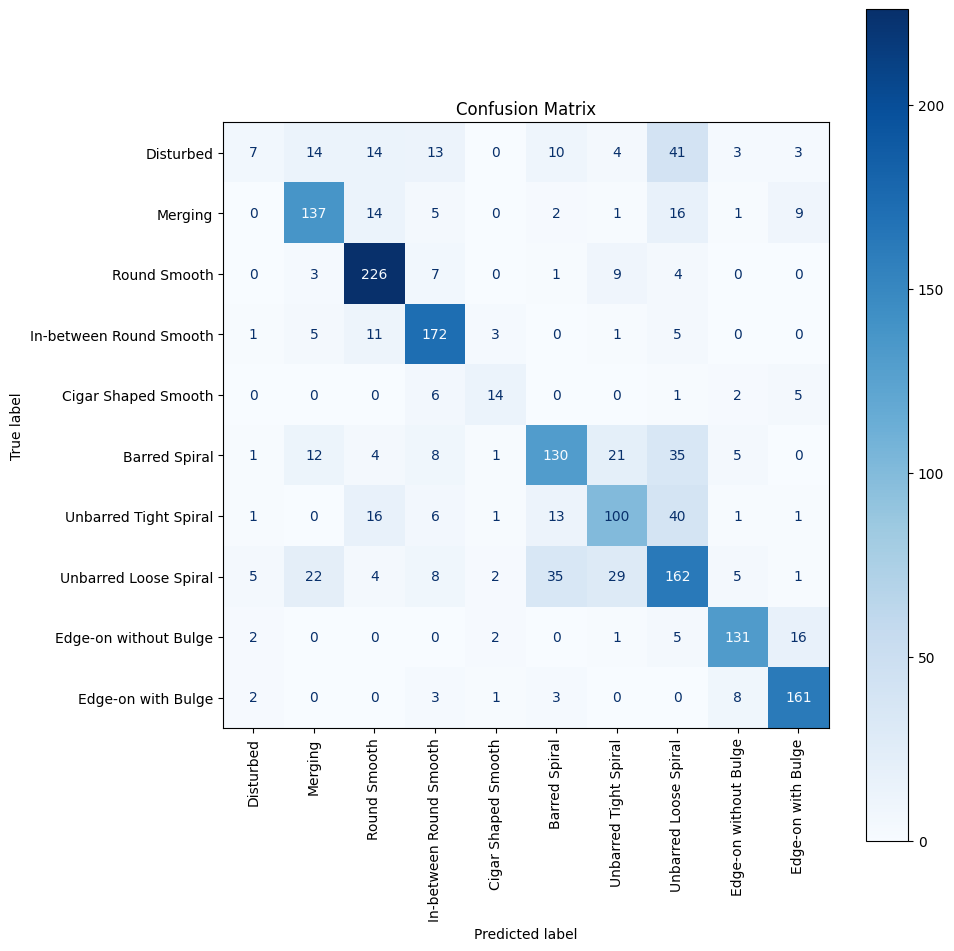

In [ ]:
true_test_labels = galaxy_dataset["test"]["label"]
test_metrics = evaluate_predictions(preds, true_test_labels, class_names)